In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import seaborn as sns
import tensorflow as tf
tf.__version__

'2.0.0-beta0'

In [4]:
from environment import TradingEnvironment
from market_instance import new_market, make_investors

### Configuration for the synthetic market

In [5]:
config = {
    'num_investors': 10,
    'num_rounds_per_day': 3
}

### Our own portfolio

In [6]:
holdings = {
    'cash': 100000.00, 
    'TSLA': 300, 
    'AAPL': 200, 
    'MSFT': 400}

### Create the RL Environment

In [7]:
market = new_market()
environment = TradingEnvironment(config, holdings, market, 0.002)

## The market in action

In [25]:
for _ in range(360):
    market.open()
    daily = environment.let_others_trade()
    market.close()

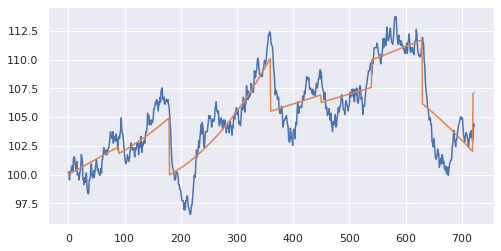

In [26]:
def plot(ticker):
    sns.set(rc={'figure.figsize':(8.0,4.0)})
    h = market.history_for(ticker)
    s = market.stocks[ticker]
    p_open, p_close, p_high, p_low = np.transpose(h)
    t = np.array(range(len(p_open)))
    sns.lineplot(t, p_open);
    sns.lineplot(t, [s.psi(tt) for tt in t]);
plot('AAPL')

## Perform an Action = Re-Balance

In [27]:
target_weights = np.array([.1, .3, .4, .2])

In [28]:
investor = environment.investor
print(investor, environment.total_wealth())
environment.act(target_weights)
print(investor, environment.total_wealth())

WB (cash: 50729.357, {'TSLA': 694, 'AAPL': 228, 'MSFT': 351}) 256514.528
WB (cash: 51397.983, {'TSLA': 652, 'AAPL': 243, 'MSFT': 372}) 258177.652


In [29]:
# slightly off-target because of integer stock counts and the trading costs.
environment.normalized_holdings()

array([0.10017794, 0.29890669, 0.40183546, 0.19907991])

### The ANN-based Trader Model

In [30]:
N_LSTM_NEURONS = 128
N_STOCKS = len(holdings)-1
BATCH_SIZE = 128
N_STEPS = 20                  # history length for the LSTM
N_OUT = N_STOCKS + 1          # stocks and cash
# current log returns, positions' weights, cash weight
N_FEATURES = N_STOCKS * 2 + 1

In [31]:
from models import LSTM_TraderModel

In [32]:
lstm_model = LSTM_TraderModel(
    n_neurons=N_LSTM_NEURONS, 
    n_steps=N_STEPS,
    n_features=N_FEATURES,
    n_out=N_OUT)

x = np.random.random(
    [BATCH_SIZE, N_STEPS, N_FEATURES]).astype(np.float32)

y = lstm_model(x) # initialize the model
test_portfolio = lstm_model.portfolio(x)
lstm_model.summary()

Model: "lstm__trader_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                multiple                  69632     
_________________________________________________________________
dense_1 (Dense)              multiple                  516       
Total params: 70,148
Trainable params: 70,148
Non-trainable params: 0
_________________________________________________________________


In [39]:
x = np.random.random(
    [1, 9, N_FEATURES]).astype(np.float32)
x

array([[[0.6722251 , 0.74916065, 0.00904258, 0.5959885 , 0.03964569,
         0.47501665, 0.09373061],
        [0.8632581 , 0.93758345, 0.75324184, 0.19776052, 0.6258283 ,
         0.03747427, 0.774662  ],
        [0.13791808, 0.11817594, 0.01047339, 0.65062034, 0.72617674,
         0.8835994 , 0.08230842],
        [0.2664535 , 0.5501977 , 0.03348064, 0.41466787, 0.63728935,
         0.833956  , 0.47688234],
        [0.99581796, 0.5445582 , 0.297522  , 0.66326374, 0.9793669 ,
         0.6744642 , 0.35366714],
        [0.08316811, 0.33578393, 0.28114423, 0.12159295, 0.64710337,
         0.38306117, 0.9242966 ],
        [0.45360675, 0.5489621 , 0.8808504 , 0.133714  , 0.0540752 ,
         0.4708008 , 0.10320526],
        [0.5668354 , 0.9527842 , 0.17538731, 0.42997783, 0.8036596 ,
         0.93531555, 0.9991067 ],
        [0.6179493 , 0.9834799 , 0.70258415, 0.39528507, 0.21089423,
         0.39900935, 0.8837358 ]]], dtype=float32)

In [17]:
weights = lstm_model.get_weights()

In [40]:
lstm_model.portfolio(x)

<tf.Tensor: id=991, shape=(1, 4), dtype=float32, numpy=array([[0.20032825, 0.3224517 , 0.24927798, 0.22794211]], dtype=float32)>

### Observation And Reward
The observation consists of the normalized holdings and the normalized log returns of the traded assets with respect to the closing prices. 

In [35]:
obs, reward = environment.act([.2, .2, .3, .3])
print("Observations: 4x normalized holdings, 3x normalized log returns:")
print(obs)
print("Reward: %s" % reward)

Observations: 4x normalized holdings, 3x normalized log returns:
[ 0.19906889  0.19970232  0.30217871  0.29905008 -0.09830638 -0.05044918
  0.85124445]
Reward: 0.001380502410635245
